# **4.8** - UNet Image segmentation

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False);

/content/init.py:2: SyntaxWarning: invalid escape sequence '\S'
  course_id = '\S*deeplearning\S*'


replicating local resources


## Some general references on segmentation

- [https://neptune.ai/blog/image-segmentation-in-2020](https://neptune.ai/blog/image-segmentation-in-2020)
- [https://nanonets.com/blog/semantic-image-segmentation-2020/](https://nanonets.com/blog/semantic-image-segmentation-2020/)
- [https://debuggercafe.com/introduction-to-image-segmentation-in-deep-learning/](https://debuggercafe.com/introduction-to-image-segmentation-in-deep-learning/)
- [https://beerensahu.wordpress.com/2019/02/07/explained-deeplab-for-semantic-segmentation/](https://beerensahu.wordpress.com/2019/02/07/explained-deeplab-for-semantic-segmentation/)

## Use GPU runtime!!!

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.19.0'

In [3]:
# this will only work if you have a GPU environment
!nvidia-smi

Thu Sep  4 00:14:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Image Segmentation

This notebook is adapted from this Keras Competition: [Data Science Bowl 2018](https://www.kaggle.com/c/data-science-bowl-2018)

[https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277/notebook)

From the competition [Data Section](https://www.kaggle.com/c/data-science-bowl-2018/data) download the file `stage1_train.zip` and `stage1_test.zip`, unzip them, make it available somewhere in the file system and update the `TRAIN_PATH` and `TEST_PATH` variables accordingly below.

Alternatively, you can use the `kaggle api` to download them automatically. This is convenient in Google Colab since the data transfer will happen directly between kaggle and colab. To do this

1. download the `kaggle.json` file from your Kaggle account under **Create new API token**
2. upload it to your Colab notebook environment
3. execute the following cell

If kaggle utilities are not installed in your environment make sure to also execute

    pip install kaggle

In [19]:
%%bash
export KAGGLE_CONFIG_DIR=.
chmod 600 kaggle.json
kaggle competitions download data-science-bowl-2018 -f stage1_train.zip
kaggle competitions download data-science-bowl-2018 -f stage1_test.zip

100%|██████████| 79.1M/79.1M [00:00<00:00, 1.36GB/s]
100%|██████████| 9.10M/9.10M [00:00<00:00, 722MB/s]


In [20]:
!unzip -o stage1_test.zip -d stage1_test > /dev/null
!unzip -o stage1_train.zip -d stage1_train > /dev/null

## Intro
Hello! This rather quick and dirty kernel shows how to get started on segmenting nuclei using a neural network in Keras.

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [21]:
from progressbar import progressbar as pbar
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf
print (tf.__version__)
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

2.19.0


In [22]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

Observe some image sizes and their variability

In [23]:
for n, id_ in enumerate(np.random.permutation(train_ids)[:10]):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    print(img.shape)

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(520, 696, 3)
(256, 256, 3)
(512, 640, 3)
(1024, 1024, 3)
(256, 320, 3)
(1040, 1388, 3)
(256, 320, 3)


In [24]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in pbar(enumerate(train_ids), max_value=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask


# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in pbar(enumerate(test_ids), max_value=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100% (670 of 670) |######################| Elapsed Time: 0:04:24 Time:  0:04:24


Getting and resizing test images ... 


100% (65 of 65) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Done!


In [25]:
# selected VALIDATION IDs
ids = [61, 59, 24, 39, 49]


Let's see if things look all right by drawing some random images and their associated masks.

603
[61, 59, 24, 39, 49]


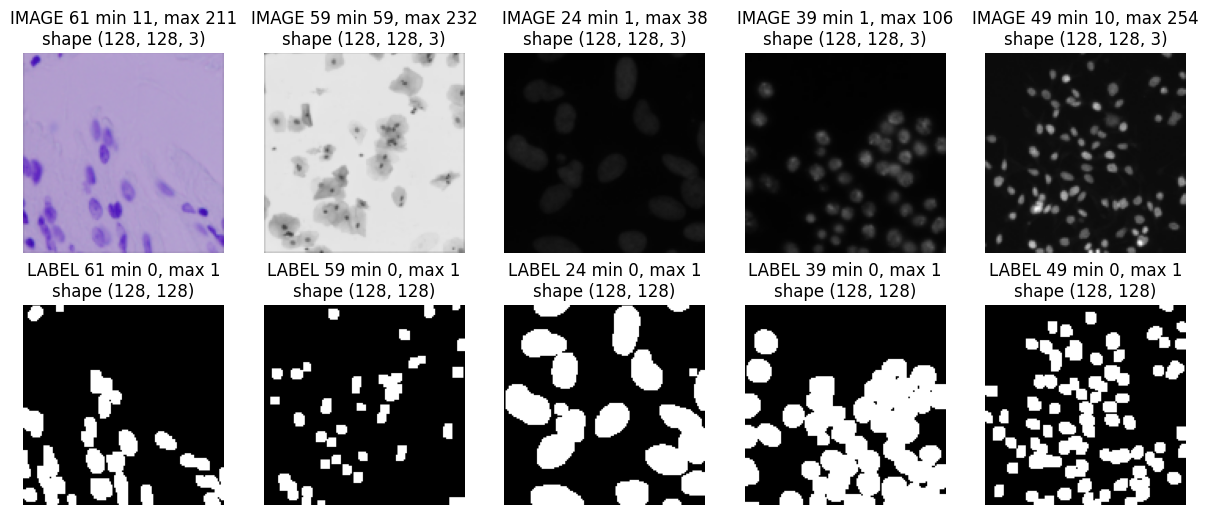

In [26]:
def show_img(img, title="", cmap=None, details=True):
    plt.imshow(img, cmap=cmap)
    if details:
        plt.title("%s min %d, max %d\nshape %s"%(title, np.min(img), np.max(img), str(img.shape)))
    else:
        plt.title(title)
    plt.axis("off")

ival = int(X_train.shape[0]*0.9)
print(ival)
plt.figure(figsize=(15,6))
print (ids)
for c,i in enumerate(ids):
    plt.subplot(2,5,c+1)
    img = X_train[ival+i]
    show_img(img, "IMAGE %d"%i)
    plt.subplot(2,5,c+6)
    show_img(np.squeeze(Y_train[ival+i]), "LABEL %d"%i, cmap=plt.cm.Greys_r)

Seems good!


## Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [27]:
def get_model_UNET(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=3):

    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

In [28]:
model = get_model_UNET()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

*Update: Changed to ELU units, added dropout.*

Next we fit the model on the training data, using a validation split of 0.1. We use a small batch size because we have so little data. I recommend using checkpointing and early stopping when training your model. I won't do it here to make things a bit more reproducible (although it's very likely that your results will be different anyway). I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters.

*Update: Added early stopping and checkpointing and increased to 30 epochs.*

### you may skip this step by downloading directly the pretrained weights

In [29]:
!wget -nc https://s3.amazonaws.com/rlx/model-dsbowl2018-1.h5

--2025-09-04 00:30:27--  https://s3.amazonaws.com/rlx/model-dsbowl2018-1.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.39.216, 16.15.196.0, 54.231.130.104, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.39.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23524888 (22M) [application/x-hdf]
Saving to: ‘model-dsbowl2018-1.h5’

model-dsbowl2018-1. 100%[===================>]  22.43M  26.1MB/s    in 0.9s    

2025-09-04 00:30:29 (26.1 MB/s) - ‘model-dsbowl2018-1.h5’ saved [23524888/23524888]



In [30]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30,
                    callbacks=[earlystopper, checkpointer])

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.4625
Epoch 1: val_loss improved from inf to 0.23217, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 235ms/step - loss: 0.4608 - val_loss: 0.2322
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1774
Epoch 2: val_loss improved from 0.23217 to 0.17737, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1772 - val_loss: 0.1774
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1628
Epoch 3: val_loss did not improve from 0.17737
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1627 - val_loss: 0.1820
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1394
Epoch 4: val_loss improved from 0.17737 to 0.14883, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1394 - val_loss: 0.1488
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1394
Epoch 5: val_loss improved from 0.14883 to 0.11482, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1394 - val_loss: 0.1148
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1166
Epoch 6: val_loss improved from 0.11482 to 0.10615, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1166 - val_loss: 0.1061
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1070
Epoch 7: val_loss improved from 0.10615 to 0.10025, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1071 - val_loss: 0.1003
Epoch 8/30
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1062
Epoch 8: val_loss did not improve from 0.10025
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1061 - val_loss: 0.1009
Epoch 9/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1000
Epoch 9: val_loss did not improve from 0.10025
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1000 - val_loss: 0.1008
Epoch 10/30
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1032
Epoch 10: val_loss improved from 0.10025 to 0.09507, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.1031 - val_loss: 0.0951
Epoch 11/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0945
Epoch 11: val_loss did not improve from 0.09507
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0945 - val_loss: 0.0954
Epoch 12/30
74/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0882
Epoch 12: val_loss improved from 0.09507 to 0.08887, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0883 - val_loss: 0.0889
Epoch 13/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0900
Epoch 13: val_loss did not improve from 0.08887
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0900 - val_loss: 0.0990
Epoch 14/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0871
Epoch 14: val_loss did not improve from 0.08887
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0871 - val_loss: 0.0893
Epoch 15/30
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0851
Epoch 15: val_loss did not improve from 0.08887
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0852 - val_loss: 0.0941
Epoch 16/30
75/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0874
Epoch 16: val_loss improved from 0.08887 to 0.08873, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0874 - val_loss: 0.0887
Epoch 17/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0878
Epoch 17: val_loss improved from 0.08873 to 0.08503, saving model to model-dsbowl2018-1.h5


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0877 - val_loss: 0.0850
Epoch 18/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0812
Epoch 18: val_loss did not improve from 0.08503
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0813 - val_loss: 0.0974
Epoch 19/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0876
Epoch 19: val_loss did not improve from 0.08503
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0875 - val_loss: 0.0886
Epoch 20/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0853
Epoch 20: val_loss did not improve from 0.08503
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0853 - val_loss: 0.0904
Epoch 21/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0805
Epoch 21: val_loss did not improve from 0.08503
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0805 - val_loss: 0.0875
Epoch 22/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0835
Epoch 22: val_loss did not improve from 0.08503
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0834 

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters!

## Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [31]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5')
preds_train = model.predict(X_train[:ival], verbose=1)
preds_val = model.predict(X_train[ival:], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


## performance on selected validation data

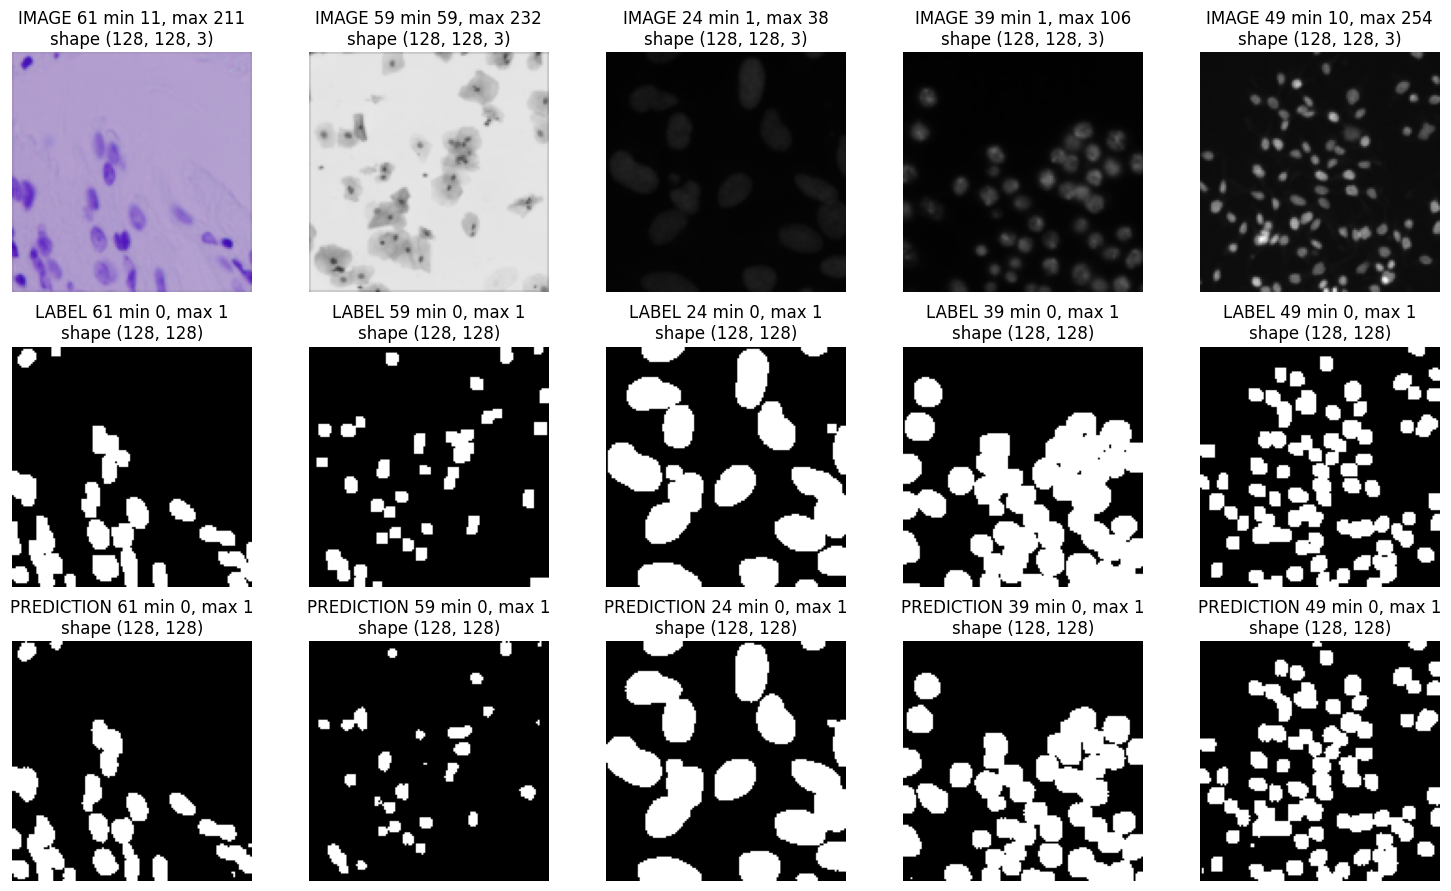

In [32]:
plt.figure(figsize=(15,9))
for c,i in enumerate(ids):
    plt.subplot(3,5,c+1)
    show_img(X_train[ival+i], "IMAGE %d"%i)
    plt.subplot(3,5,c+6)
    show_img(np.squeeze(Y_train[ival+i]), "LABEL %d"%i, cmap=plt.cm.Greys_r)
    plt.subplot(3,5,c+11)
    show_img(np.squeeze(preds_val_t[i]), "PREDICTION %d"%i, cmap=plt.cm.Greys_r)
plt.tight_layout()

## And on test data

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

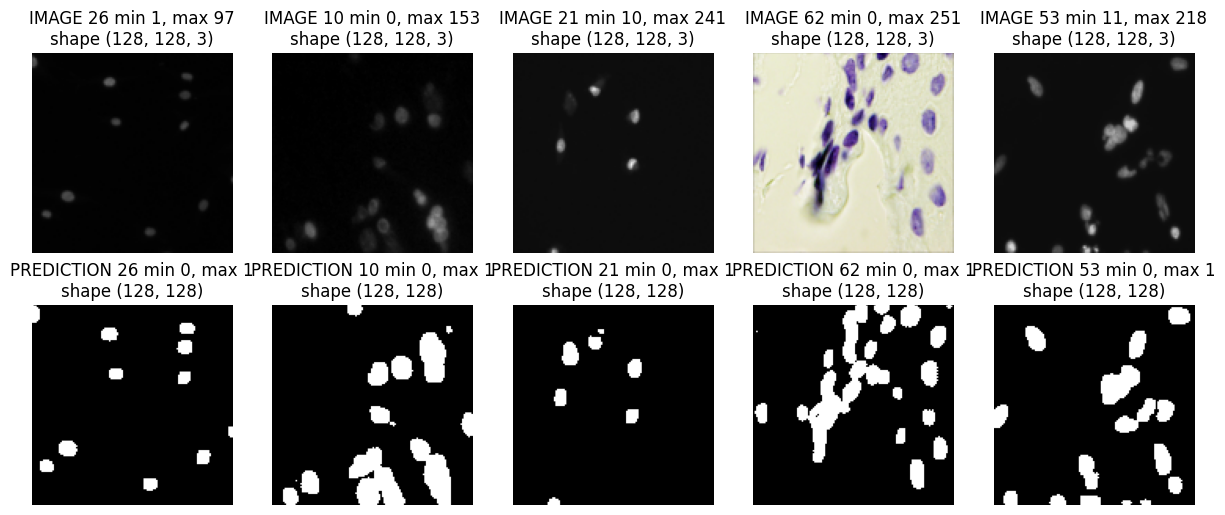

In [33]:
plt.figure(figsize=(15,6))
ids = np.random.permutation(len(preds_test))[:5]
for c,i in enumerate(ids):
    plt.subplot(2,5,c+1)
    show_img(X_test[i], "IMAGE %d"%i)
    plt.subplot(2,5,c+6)
    show_img(np.squeeze(preds_test_t[i]), "PREDICTION %d"%i, cmap=plt.cm.Greys_r)